### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# install local geoopt first: !pip install -e data/geoopt
import geoopt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr
import matplotlib.patheffects as PathEffects

import _utils
from _utils import set_all_seeds, set_plt_layout
from _utils import calculate_reconstruction_metrics_hmtDNA, calculate_correlation_metrics_hmtDNA
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

_utils.reset_plt_layout()
set_all_seeds(0); set_plt_layout()

### Prepare data

In [3]:
df = pd.read_pickle("data/hmtDNA/rsrs.pkl", compression='gzip')
df

,SampleID,Haplogroup,Rank,Quality,Range,Not_Found_Polys,Found_Polys,Remaining_Polys,AAC_In_Remainings,Input_Sample,main_geo_loc,sub_geo_loc,latitude,longitude,distance_to_sudan
0,AB055387.1,B5b1a2,1,0.9397,1-16569,182T 960.1C 9540T 11914G 15301A 16223C,103A 146T 152T 182C! 195T 199C 204C 247G 709A ...,311d (globalPrivateMutation) 523d (hotspot) 52...,NaN,"[103A, 146T, 152T, 195T, 199C, 204C, 247G, 311...",NaN,NaN,NaN,NaN,NaN
1,AB626609.1,X2e2b,1,0.9425,1-16569,182T 225A 15301A,146T 152T 153G 182C! 195T! 225G! 247G 769G 825...,309.1C (hotspot) 315.1C (hotspot) 522.1ACA (gl...,NaN,"[146T, 152T, 153G, 247G, 309.1C, 315.1C, 522.1...",NaN,NaN,NaN,NaN,NaN
2,AB626610.1,H3u1,1,0.9672,1-16569,182T 15301A,73A 146T 152T 182C! 195T 247G 769G 825T 1018G ...,315.1C (hotspot) 523A (globalPrivateMutation) ...,NaN,"[73A, 146T, 152T, 195T, 247G, 315.1C, 523A, 52...",NaN,NaN,NaN,NaN,NaN
3,AF346963.1,S1,1,0.8897,1-16569,152T 182T 15301A,146T 182C! 195T 247G 769G 825T 1018G 2758G 288...,150T (localPrivateMutation) 252C (localPrivate...,12358G [T8A| Codon 1 | ND5 ] 13594G [S420G| Co...,"[146T, 150T, 195T, 247G, 252C, 315.1C, 523A, 5...",Australia,NaN,-24.776109,134.755000,11927.501388
4,AF346964.1,S2,1,0.8606,1-16569,182T 7521G 15301A,146T 152T 182C! 195T 247G 769G 825T 1018G 2380...,309.1C (hotspot) 315.1C (hotspot) 471C (localP...,13135A [A267T| Codon 1 | ND5 ] 13708A [A458T| ...,"[146T, 152T, 195T, 247G, 309.1C, 315.1C, 471C,...",Australia,NaN,-24.776109,134.755000,11927.501388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63773,PQ468427.1,HV6a,1,0.9774,1-16569,182T 15301A,73A 146T 152T 182C! 195T 247G 769G 825T 1018G ...,309.1C (hotspot) 315.1C (hotspot) 523A (global...,NaN,"[73A, 146T, 152T, 195T, 247G, 309.1C, 315.1C, ...",Poland,NaN,52.215933,19.134422,4251.500278
63774,PQ468428.1,H7a1,1,0.9621,1-16569,182T 15301A,73A 146T 152T 182C! 195T 247G 769G 825T 1018G ...,315.1C (hotspot) 523A (globalPrivateMutation) ...,NaN,"[73A, 146T, 152T, 195T, 247G, 315.1C, 523A, 52...",Poland,NaN,52.215933,19.134422,4251.500278
63775,PQ468429.1,H1c+152C!,1,0.9442,1-16569,146T 182T 15301A,73A 152T! 182C! 195T 247G 477C 769G 825T 1018G...,315.1C (hotspot) 326G (localPrivateMutation) 5...,NaN,"[73A, 195T, 247G, 315.1C, 326G, 477C, 523A, 52...",Poland,NaN,52.215933,19.134422,4251.500278
63776,V00662.1,H2a2a1,1,0.9579,1-16569,182T 14766C 15301A,73A 146T 152T 182C! 195T 247G 263A 750A 769G 8...,523A (globalPrivateMutation) 524C (globalPriva...,9559G [P118R| Codon 2 | COX3 ] 11447C [V230L| ...,"[73A, 146T, 152T, 195T, 247G, 263A, 523A, 524C...",NaN,NaN,NaN,NaN,NaN


In [39]:
thr = 0.9
print(set(df[df['Quality'] < thr]["Haplogroup"]) - set(df[df['Quality'] >= thr]["Haplogroup"]))

df = df[df['Quality'] >= thr]
df.shape

{'L0f1', 'F1c1', 'U5b', 'M69', "L0a1'4", 'L1c4', 'L1c1', 'M13', 'Z', 'P3b', "M24'41", 'L0a1', 'L4b1', 'C4a2', "M1'20'51", 'L0a', 'H60', 'P9', 'P4b', 'L1c3', 'M42', 'F3b', 'C4a1a', "M34'57", 'M34a', 'U1a', 'C1b8', "L0a'g", 'M7b', 'L3h1a2', 'L5b1', 'N10', 'M5b2b1', 'L2a5', "M19'53", 'K1b1', 'N1a1a1', 'R7', 'M33+16362C ', 'P+16176T ', 'M60a', 'L0f', 'R6a', 'F1b', "L1c1'2'4'6", 'M42b2', "R11'B6", 'M50a', 'M46', 'L3a+709A ', "L1c1'2'4'5'6", 'P6', "L3e3'4'5", 'L1c3a1', 'mtMRCA', 'M43', 'L0a1c', 'L3h1b1', 'L0b', 'R30', 'L1c1a', 'U8b1a2+16311T! ', 'R30b', 'L3x1a1', 'M68', 'L0f2a', 'M12a', 'L3f2a', 'L2a2b', 'F1+16189T! ', 'T2d1', 'L3e2a1', "L2'3'4'5'6", 'F2b', 'B5b', 'D4g2a', 'M21b+210G ', 'C5b', 'M17', 'L0a3', 'M22b', 'R6+16129G! ', 'R5a', 'L1c6', 'L3a2', 'B4', 'G2a1f', "L2b'c'd", 'Z3+709A ', 'M37+152C! ', "M2a'b", 'M21b1', "L0d2a'b'd", "M39'70", 'U2a'}


(61665, 15)

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['Input_Sample'].values),
                       columns=mlb.classes_,
                       index=df.index)


# Calculate the frequency of each mutation
mutation_counts = one_hot.sum(axis=0)
total_samples = one_hot.shape[0]
mutation_frequencies = mutation_counts / total_samples

# Display mutation frequencies
print("\nMutation Frequencies:")
print(mutation_frequencies.head())

frequency_threshold = 0.0005
filtered_mutations = mutation_frequencies[mutation_frequencies >= frequency_threshold].index
one_hot_filtered = one_hot[filtered_mutations]
# (61665, 6298)

# Display the filtered one-hot encoded DataFrame
print(f"\nFiltered One-Hot Encoded DataFrame (Mutations with ≥ {frequency_threshold*100}% Frequency):")
print(one_hot_filtered.shape)



Mutation Frequencies:
10000A    0.000049
10000N    0.001087
10001N    0.001103
10002N    0.001038
10003C    0.000178
dtype: float64

Filtered One-Hot Encoded DataFrame (Mutations with ≥ 0.05% Frequency):
(61665, 6298)


In [41]:
df['n_mutations'] = df['Input_Sample'].apply(len)
df['n_kept_mutations'] = one_hot_filtered.sum(axis=1)
df['kept_ratio'] = df['n_kept_mutations'] / df['n_mutations'] 

print(one_hot_filtered.shape)
df[['n_mutations', 'n_kept_mutations']].describe()

# optionally only keep samples where ratio is above 0.5
# df = df[df['kept_ratio'] > 0.9]

/tmp/ipykernel_1339143/3940055659.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_mutations'] = df['Input_Sample'].apply(len)


(61665, 6298)


/tmp/ipykernel_1339143/3940055659.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_kept_mutations'] = one_hot_filtered.sum(axis=1)
/tmp/ipykernel_1339143/3940055659.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kept_ratio'] = df['n_kept_mutations'] / df['n_mutations']


,n_mutations,n_kept_mutations
count,61665.000000,61665.000000
mean,63.452234,59.367453
std,85.376423,39.319714
min,30.000000,9.000000
25%,53.000000,52.000000
50%,57.000000,56.000000
75%,62.000000,61.000000
max,4446.000000,1780.000000


In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse('trees/phylotree-rsrs/17.0/tree.xml')
root = tree.getroot()

haplogroup_levels = {}

def traverse(node, level):
    haplogroup_name = node.get('name')
    if haplogroup_name:
        haplogroup_levels[haplogroup_name] = level
    for child in node.findall('haplogroup'):
        traverse(child, level + 1)

traverse(root, 0)
haplogroup_levels.pop('mtMRCA', None)
haplogroup_levels = {k: v - 2 for k, v in haplogroup_levels.items()}


df['level'] = df['Haplogroup'].map(haplogroup_levels)
assert df['level'].isna().sum() == 0
df['level'] = df['level'].astype(int)

print(haplogroup_levels, df['level'].value_counts())


In [46]:
class Nodes(torch.utils.data.Dataset):
    def __init__(self, dataset, subset=None, level=None, haplogroup=None, obs=None):
        super(Nodes, self).__init__()
        self.data = dataset[subset] if subset is not None else dataset
        if level is not None: self.level = level[subset] if subset is not None else level
        if haplogroup is not None: self.haplogroup = haplogroup[subset] if subset is not None else haplogroup
        if obs is not None: self.obs = obs.iloc[subset] if subset is not None else obs

        self.data = torch.tensor(self.data, dtype=torch.float64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return index, self.data[index], index

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

data = torch.tensor(one_hot_filtered.loc[df.index.tolist()].values, dtype=torch.float64)

In [47]:
set_all_seeds(0)

# Split data into train, validation and test sets (82/9/9)
indices = np.arange(len(data))
np.random.shuffle(indices)

train_size = int(0.82 * len(indices))
val_size = int(0.09 * len(indices))
test_size = len(indices) - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_data = Nodes(data, train_indices, level=df['level'].values, haplogroup=df['Haplogroup'].values, obs=df)
val_data = Nodes(data, val_indices, level=df['level'].values, haplogroup=df['Haplogroup'].values, obs=df)
test_data = Nodes(data, test_indices, level=df['level'].values, haplogroup=df['Haplogroup'].values, obs=df)

batch_size = 2048 # 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_1339143/3185874923.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype=torch.float64)


### UMAP

In [48]:
import umap

reducer = umap.UMAP(n_components=2, n_jobs=8, n_neighbors=30, min_dist=0.99)
umap_embeddings = reducer.fit_transform(train_data.data)

2025-05-23 11:27:15.944696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 11:27:15.957791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 11:27:15.971922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 11:27:15.976179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 11:27:15.989766: I tensorflow/core/platform/cpu_feature_guar

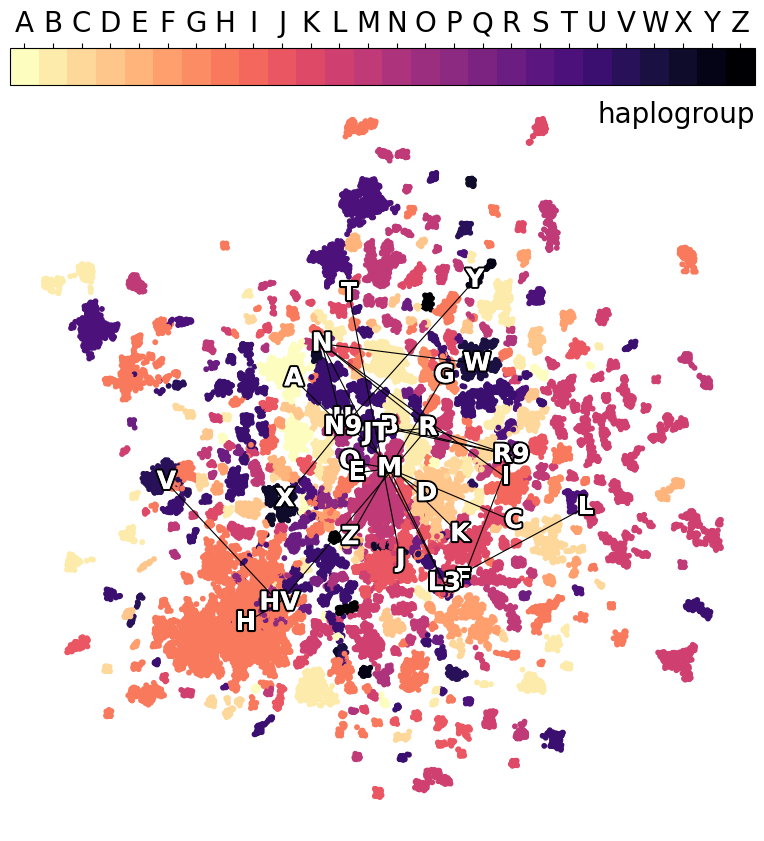

In [49]:
kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values
z_p = umap_embeddings[kept]
obs = train_data.obs[kept]

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M', 'Q'),
    ('R','HV'),('R','JT'),
    ('R', 'R9'), ('R9', 'U'), ('U', 'K'), ('R9', 'B'), ('R9', 'F'),
    ('N','W'),('N','I'), ('N', 'N9'),
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

nodes = {n for e in edges for n in e}
medians = {}
for lbl in nodes:
    if lbl == 'L':
        mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
    elif lbl == 'N':
        mask = obs.Haplogroup.str.startswith('N2') 
    elif lbl == 'L3':
        mask = obs.Haplogroup.str.startswith('L3')
    elif lbl == 'HV':
        mask = obs.Haplogroup.str.startswith('HV') 
    elif lbl == 'JT':
        mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
    elif lbl == 'R':
        mask = obs.Haplogroup.str.startswith('R2')
    elif lbl == 'R9':
        mask = obs.Haplogroup.str.startswith('R9')
    elif lbl == 'U':
        mask = obs.Haplogroup.str.startswith('U')
    elif lbl == 'N9':
        mask = obs.Haplogroup.str.startswith('N9')
    else:
        mask = obs.Haplogroup.str[:1] == lbl
    if mask.any():
        medians[lbl] = (
            np.median(z_p[mask,0]),
            np.median(z_p[mask,1])
        )
fig, ax = plt.subplots(figsize=(8,8.5))
ax.scatter(z_p[:,0], z_p[:,1], c=codes1, s=10, cmap='magma_r')
# ax.scatter(z_p[:,0], z_p[:,1], c=obs["level"], s=10, cmap='magma_r')

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0)
cbar = fig.colorbar(
    ax.collections[0], cax=cax,
    orientation='horizontal',
    boundaries=np.arange(len(labels1)+1)-0.5,
    ticks=np.arange(len(labels1))
)
cbar.set_label("")

cax.text(
    1, -0.8, "haplogroup",
    va='center', ha='right',
    fontsize=20, 
    transform=cax.transAxes,
    rotation=0
)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.ax.set_xticks(np.arange(len(labels1)))
cbar.ax.set_xticklabels(labels1, fontsize=20)
cbar.ax.tick_params(labelsize=20)
cbar.ax.minorticks_off()

# FOR LEVEL
# cbar = fig.colorbar(ax.collections[0], cax=cax,location='left', label='Level')

for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

ax.set_aspect('equal', 'box')
plt.tight_layout()
# ax.set_xlabel('UMAP 1')
# ax.set_ylabel('UMAP 2')
# plt.savefig(f'results/pdfs/final_hmtdna_rsrs_umap2.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_hmtdna_rsrs_umap2.png', dpi=300, bbox_inches='tight')
plt.show()


### Model definition

In [51]:
# ---------------------------------
# - Riemannian generative decoder - 
# ---------------------------------

class RGD(nn.Module):
    def __init__(self, dim_list, manifold=geoopt.manifolds.Euclidean(), output_activation=None):
        super(RGD, self).__init__()
        self.dim_list = dim_list 
        self.manifold = manifold 
        self.origin = self.manifold.origin(dim_list[0], seed=None, device=device)
        
        # fc decoder stack with swish activations 
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i != len(dim_list) - 2: # only activations for hidden layers
                layers.append(nn.SiLU())
                
        if output_activation is not None:
            layers.append(output_activation)

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        return self.decoder(z)

    def init_samples(self, n):
        # manifold-projected points with small noise opposite origin 
        z = 1e-3 * torch.randn(n, self.dim_list[0], device=device) - self.origin 
        z = self.manifold.projx(z)
        return geoopt.ManifoldParameter(z, manifold=self.manifold, requires_grad=True)
    
from _train import train_rgd
torch.set_default_dtype(torch.float64)  # Set default tensor type


In [54]:
# define parameters 
device = "cuda:1"
dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]]

c = 5; std = 0.5
manifold = geoopt.manifolds.Lorentz(k=c)
# manifold = geoopt.manifolds.Euclidean(1); use_prior = True

# initialize and train model
model = RGD(dim_list, manifold)
model.z = model.init_samples(len(train_data))
model.z_val = model.init_samples(len(val_data))
train_rgd(model, F.binary_cross_entropy_with_logits, train_loader, val_loader, [1e-1, 2e-3], betas=(0.9, 0.995), 
    n_epochs=1000, device=device, patience=85, start_saving=150, wd=1e-3, noise_std=std, use_prior=False)

# find test-time representations 
loss_fn = lambda x, y: F.binary_cross_entropy_with_logits(x, y, reduction='none')
ztest = _utils.get_representations(model, test_loader, loss_fn, n_start_points_per_sample=15, n_epochs=600, lr=8e-2, betas=(0.5, 0.7), wd=0, device=device)
model.z_test = ztest

### Evaluation

In [62]:
# Compute results 
pearson, spearman = calculate_correlation_metrics_hmtDNA(model.z, manifold, train_data)
test_pearson, test_spearman = calculate_correlation_metrics_hmtDNA(model.z_test, manifold, test_data)
train_bce, train_f1 = calculate_reconstruction_metrics_hmtDNA(model, model.z, train_data)
test_bce, test_f1 = calculate_reconstruction_metrics_hmtDNA(model, model.z_test, test_data)
print(f"Train: Pearson={round(pearson, 3)}, Spearman={round(spearman, 3)}, BCE={round(train_bce, 3)}, F1={round(train_f1, 3)}")
print(f" Test: Pearson={round(test_pearson, 3)}, Spearman={round(test_spearman, 3)}, BCE={round(test_bce, 3)}, F1={round(test_f1, 3)}")

Train: Pearson=0.295, Spearman=0.497, BCE=0.009, F1=0.858
 Test: Pearson=0.17, Spearman=0.363, BCE=0.009, F1=0.877


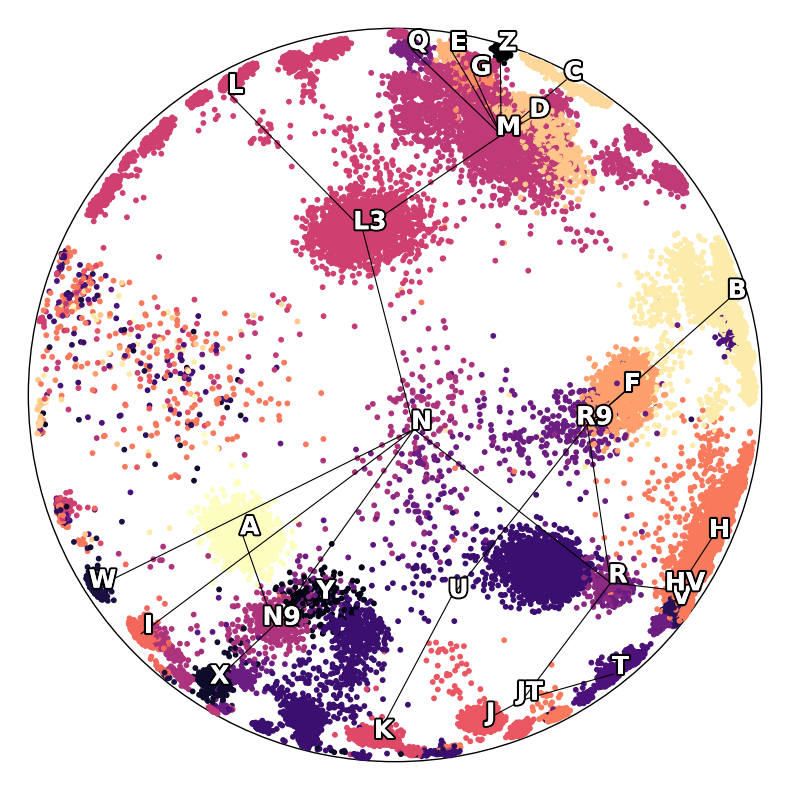

In [63]:
disk_radius = 1

def lorentz_to_poincare(z, k=c):
    return z[:, 1:] / (z[:, :1])

kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values
z = model.z[kept]
obs = train_data.obs[kept]
z_p = lorentz_to_poincare(z)
z_p = z_p.data.cpu().numpy()

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M', 'Q'),
    ('R','HV'),('R','JT'),
    ('R', 'R9'), ('R9', 'U'), ('U', 'K'), ('R9', 'B'), ('R9', 'F'),
    ('N','W'),('N','I'), ('N', 'N9'),
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

nodes = {n for e in edges for n in e}
medians = {}
for lbl in nodes:
    if lbl == 'L':
        mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
    elif lbl == 'N':
        mask = obs.Haplogroup.str.startswith('N2') 
    elif lbl == 'L3':
        mask = obs.Haplogroup.str.startswith('L3')
    elif lbl == 'HV':
        mask = obs.Haplogroup.str.startswith('HV') 
    elif lbl == 'JT':
        mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
    elif lbl == 'R':
        mask = obs.Haplogroup.str.startswith('R2') 
    elif lbl == 'R9':
        mask = obs.Haplogroup.str.startswith('R9')
    elif lbl == 'U':
        mask = obs.Haplogroup.str.startswith('U')
    elif lbl == 'N9':
        mask = obs.Haplogroup.str.startswith('N9')
    else:
        mask = obs.Haplogroup.str[:1] == lbl
    if mask.any():
        medians[lbl] = (
            np.median(z_p[mask,0]),
            np.median(z_p[mask,1])
        )

fig, ax = plt.subplots(figsize=(8,8))
ax.add_artist(plt.Circle((0,0), disk_radius, fill=False, color='black'))
# ax.scatter(z_p[:,0], z_p[:,1], c=obs['level'], s=10, cmap='magma')
ax.scatter(z_p[:,0], z_p[:,1], c=codes1, s=10, cmap='magma_r')


for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_hmtdna_rsrs{std:.1f}std.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_hmtdna_rsrs{std:.1f}std.png', dpi=300, bbox_inches='tight')
plt.show()


### Further statistics and plotting

In [64]:
from copy import deepcopy
from geoopt import manifolds
from _utils import set_all_seeds, get_representations

N_REPS = 3

loss_fn = lambda x, y: F.binary_cross_entropy_with_logits(x, y, reduction='none')
configs = [
    ("Lorentz 0.1std 5c", manifolds.Lorentz(k=5), 0.1),
    ("Lorentz 0.5std 5c", manifolds.Lorentz(k=5), 0.5),
    ("Euclidean(2)", manifolds.Euclidean(1), 0),
]
results = {}
for name, manifold, std in configs:
    print(name)
    pearsons_train, spearmans_train, bces_train, f1s_train = [], [], [], []
    pearsons_test, spearmans_test, bces_test, f1s_test = [], [], [], []
    
    for rep in range(N_REPS):  
        set_all_seeds(rep)
        dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]] 
        use_prior = False
        if name == "Euclidean(2)": 
            dim_list[0] = 2
            use_prior = True
        model = RGD(dim_list, manifold)
        model.z = model.init_samples(len(train_data))
        model.z_val = model.init_samples(len(val_data))
        train_rgd(model, F.binary_cross_entropy_with_logits, train_loader, val_loader, 
            [1e-1, 2e-3], betas=(0.9, 0.995), n_epochs=1000, device=device, beta=100, use_prior=use_prior,
            patience=85, start_saving=150, wd=1e-3, noise_std=std)

        # Train metrics
        ztrain = model.z.detach()
        p_train, s_train = calculate_correlation_metrics_hmtDNA(ztrain, manifold, train_data)
        m1_train, m2_train = calculate_reconstruction_metrics_hmtDNA(model, ztrain, train_data)
        pearsons_train.append(p_train)
        spearmans_train.append(s_train)
        bces_train.append(m1_train)
        f1s_train.append(m2_train)

        # Test metrics
        ztest = get_representations(model, test_loader, loss_fn, n_start_points_per_sample=15, n_epochs=600, lr=8e-2, betas=(0.5, 0.7), wd=0, device=device)
        model.z_test = ztest
        p_test, s_test = calculate_correlation_metrics_hmtDNA(ztest, manifold, test_data)
        m1_test, m2_test = calculate_reconstruction_metrics_hmtDNA(model, ztest, test_data)
        pearsons_test.append(p_test)
        spearmans_test.append(s_test)
        bces_test.append(m1_test)
        f1s_test.append(m2_test)

        if rep == 0:
            # save the model
            if name == "Lorentz 0.1std 5c":
                lorentz01 = deepcopy(model)
            elif name == "Euclidean(2)":
                euclidean = deepcopy(model)
        if rep == 1:
            if name == "Lorentz 0.5std 5c":
                lorentz05 = deepcopy(model)
        
    results[name] = {
        'train': {
            'pearson_mean': np.mean(pearsons_train), 'pearson_std': np.std(pearsons_train),
            'spearman_mean': np.mean(spearmans_train), 'spearman_std': np.std(spearmans_train),
            'bce_mean': np.mean(bces_train), 'bce_std': np.std(bces_train),
            'F1_mean': np.mean(f1s_train), 'F1_std': np.std(f1s_train)
        },
        'test': {
            'pearson_mean': np.mean(pearsons_test), 'pearson_std': np.std(pearsons_test),
            'spearman_mean': np.mean(spearmans_test), 'spearman_std': np.std(spearmans_test), 
            'bce_mean': np.mean(bces_test), 'bce_std': np.std(bces_test),
            'F1_mean': np.mean(f1s_test), 'F1_std': np.std(f1s_test)
        }
    }
print(results)


In [65]:
# Build a DataFrame `df` with results
idx = []
data = {}
for name, vals in results.items():
    idx.append(name)
    for split, split_name in [('train', 'Train'), ('test', 'Test')]:
        for metric, metric_name in [
            ('pearson', 'Pearson'),
            ('spearman', 'Spearman'),
            ('bce', 'BCE'),
            ('F1', 'F1')
        ]:
            m = vals[split][f'{metric}_mean']
            s = vals[split][f'{metric}_std']
            entry = f"{m:.2f}{{\\scriptsize $\\pm${s:.2f}}}"
            data.setdefault((split_name, metric_name), []).append(entry)

df = pd.DataFrame(data, index=idx)
df.index.name = 'Manifold'
cols = [(g, m) for g in ['Train', 'Test'] for m in ['Pearson', 'Spearman', 'BCE', 'F1']]
df = df[cols]

name_map = {
    "Lorentz 0.1std 5c": r"RSRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.1$)}",
    "Lorentz 0.5std 5c": r"RSRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.5$)}",
    "Euclidean(2)":      r"RSRS $\mathbb{R}^2$ {\scriptsize($\sigma=0.0$)}",
}

print(r"\begin{table}")
print(r"\caption{\textbf{Correlation and reconstruction metrics across three runs for the hmtDNA dataset (formatted as mean $\pm$ std).}}\vspace{4px}")
print(r"\label{tab:rsrs}")
print(r"\resizebox{\textwidth}{!}{%")
print(r"\begin{tabular}{c|cccc|cccc}")
print(r"\multicolumn{1}{l}{} & \multicolumn{4}{c}{\textbf{Train}} & \multicolumn{4}{c}{\textbf{Test}} \\")
print(r"& Pearson & Spearman & BCE & F1 & Pearson & Spearman & BCE & F1 \\")
print(r"\midrule")
for name in df.index:
    label = name_map.get(name, name)
    entries = [
        df.loc[name, ('Train','Pearson')],
        df.loc[name, ('Train','Spearman')],
        df.loc[name, ('Train','BCE')],
        df.loc[name, ('Train','F1')],
        df.loc[name, ('Test','Pearson')],
        df.loc[name, ('Test','Spearman')],
        df.loc[name, ('Test','BCE')],
        df.loc[name, ('Test','F1')],
    ]
    print(f"{label} & " + " & ".join(entries) + r" \\")
print(r"\end{tabular}")
print(r"}")
print(r"\end{table}")

\begin{table}
\caption{\textbf{Correlation and reconstruction metrics across three runs for the hmtDNA dataset (formatted as mean $\pm$ std).}}\vspace{4px}
\label{tab:rsrs}
\resizebox{\textwidth}{!}{%
\begin{tabular}{c|cccc|cccc}
\multicolumn{1}{l}{} & \multicolumn{4}{c}{\textbf{Train}} & \multicolumn{4}{c}{\textbf{Test}} \\
& Pearson & Spearman & BCE & F1 & Pearson & Spearman & BCE & F1 \\
\midrule
RSRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.0$)} & 0.15{\scriptsize $\pm$0.01} & 0.12{\scriptsize $\pm$0.04} & 0.00{\scriptsize $\pm$0.00} & 0.93{\scriptsize $\pm$0.00} & 0.04{\scriptsize $\pm$0.10} & 0.04{\scriptsize $\pm$0.23} & 0.02{\scriptsize $\pm$0.00} & 0.83{\scriptsize $\pm$0.02} \\
RSRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.5$)} & 0.28{\scriptsize $\pm$0.01} & 0.47{\scriptsize $\pm$0.02} & 0.01{\scriptsize $\pm$0.00} & 0.86{\scriptsize $\pm$0.00} & 0.15{\scriptsize $\pm$0.02} & 0.30{\scriptsize $\pm$0.04} & 0.01{\scriptsize $\pm$0.00} & 0.88{\scriptsize $\pm$0.00} \\
RSRS $\mathbb{R

In [66]:
# Define region mapping based on haplogroup first character
def map_region(haplogroup):
    if not isinstance(haplogroup, str) or len(haplogroup) == 0:
        return 'Other'
    first_char = haplogroup[0].upper()
    if first_char == 'L':
        return 'Africa'
    elif first_char in ['F', 'B', 'P', 'A', 'S', 'O', 'Y', 'N', 'M', 'Q', 'G', 'E', 'D', 'C', 'Z']:
        return 'Asia'
    elif first_char in ['H', 'V', 'U', 'K', 'J', 'T', 'R', 'W', 'X', 'I']:
        return 'Europe'
    else:
        return 'Other'

train_data.obs['Region'] = train_data.obs['Haplogroup'].apply(map_region)
train_data.obs['Region'].value_counts()
hap = train_data.obs.Haplogroup.str[:2].astype('category').cat.codes
muts = (train_data.obs["n_kept_mutations"]  / train_data.obs["n_mutations"]).values


/tmp/ipykernel_1339143/3541165928.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.obs['Region'] = train_data.obs['Haplogroup'].apply(map_region)


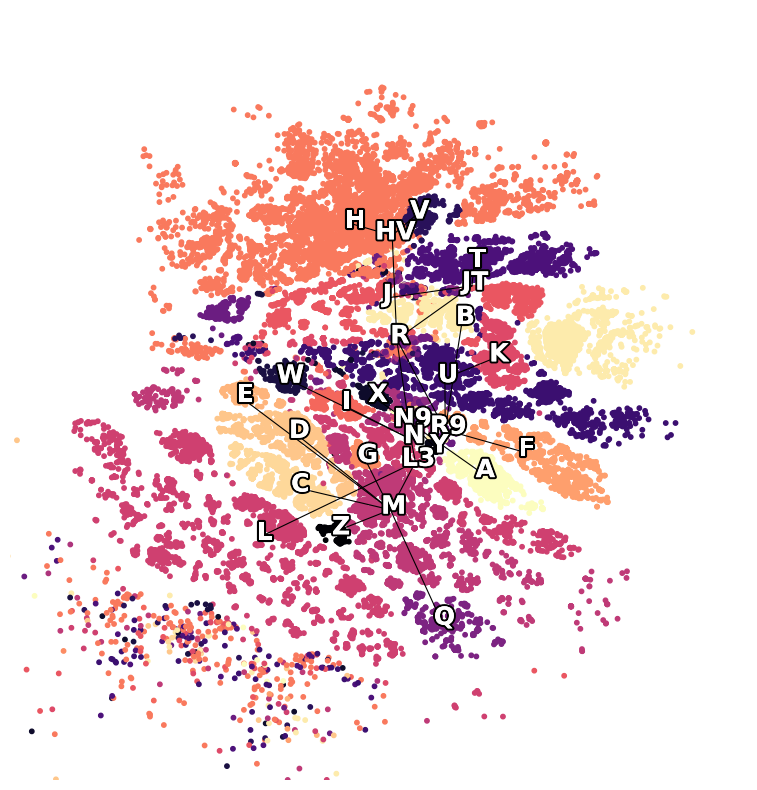

In [67]:
_utils.set_plt_layout()
disk_radius = 1

kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values
z = euclidean.z[kept]
obs = train_data.obs[kept]
z_p = z.data.cpu().numpy()

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M', 'Q'),
    ('R','HV'),('R','JT'),
    ('R', 'R9'), ('R9', 'U'), ('U', 'K'), ('R9', 'B'), ('R9', 'F'),
    ('N','W'),('N','I'), ('N', 'N9'),
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

nodes = {n for e in edges for n in e}
medians = {}
for lbl in nodes:
    if lbl == 'L':
        mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
    elif lbl == 'N':
        mask = obs.Haplogroup.str.startswith('N2') 
    elif lbl == 'L3':
        mask = obs.Haplogroup.str.startswith('L3')
    elif lbl == 'HV':
        mask = obs.Haplogroup.str.startswith('HV') 
    elif lbl == 'JT':
        mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
    elif lbl == 'R':
        mask = obs.Haplogroup.str.startswith('R2') 
    elif lbl == 'R9':
        mask = obs.Haplogroup.str.startswith('R9')
    elif lbl == 'U':
        mask = obs.Haplogroup.str.startswith('U')
    elif lbl == 'N9':
        mask = obs.Haplogroup.str.startswith('N9')
    else:
        mask = obs.Haplogroup.str[:1] == lbl
    if mask.any():
        medians[lbl] = (
            np.median(z_p[mask,0]),
            np.median(z_p[mask,1])
        )

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(z_p[:,0], z_p[:,1], c=codes1, s=10, cmap='magma_r')


for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

x_min, x_max = np.percentile(z_p[:,0], [1, 99])
y_min, y_max = np.percentile(z_p[:,1], [1, 99])

# Add a small margin
margin = 0.3 * max(x_max - x_min, y_max - y_min)
ax.set_xlim(x_min -margin, x_max + margin)
ax.set_ylim(y_min -margin, y_max + margin)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_hmtdna_rsrs_eucl.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_hmtdna_rsrs_eucl.png', dpi=300, bbox_inches='tight')
plt.show()


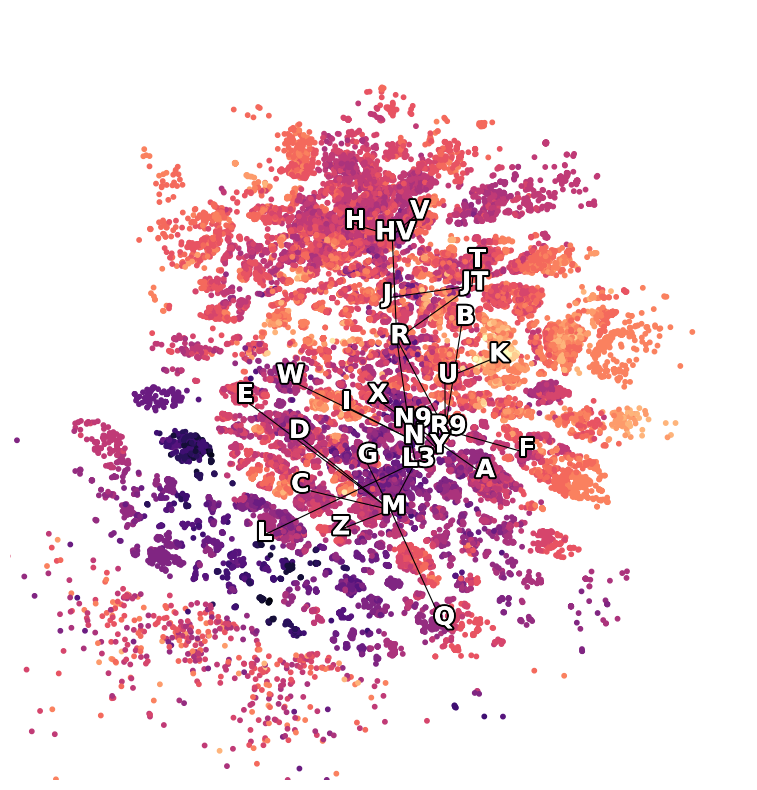

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(z_p[:,0], z_p[:,1], c=obs["level"], s=10, cmap='magma')

for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

x_min, x_max = np.percentile(z_p[:,0], [1, 99])
y_min, y_max = np.percentile(z_p[:,1], [1, 99])

# Add a small margin
margin = 0.3 * max(x_max - x_min, y_max - y_min)
ax.set_xlim(x_min -margin, x_max + margin)
ax.set_ylim(y_min -margin, y_max + margin)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_level_hmtdna_rsrs_eucl.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_level_hmtdna_rsrs_eucl.png', dpi=300, bbox_inches='tight')
plt.show()


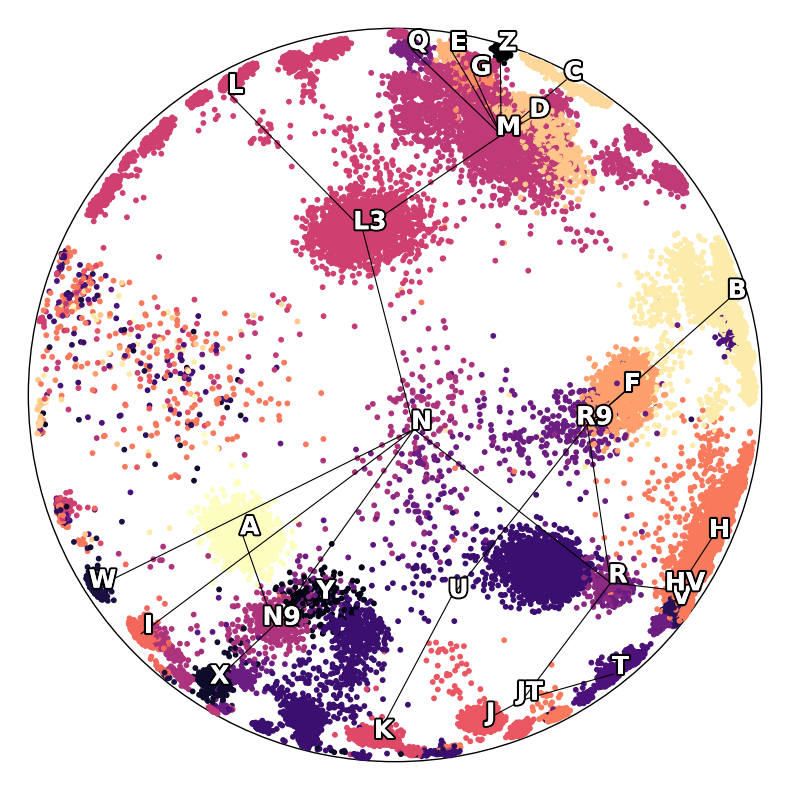

In [69]:
disk_radius = 1

def lorentz_to_poincare(z, k=c):
    return z[:, 1:] / (z[:, :1])

kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values
z = lorentz05.z[kept]
obs = train_data.obs[kept]
z_p = lorentz_to_poincare(z)
z_p = z_p.data.cpu().numpy()

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M', 'Q'),
    ('R','HV'),('R','JT'),
    ('R', 'R9'), ('R9', 'U'), ('U', 'K'), ('R9', 'B'), ('R9', 'F'),
    ('N','W'),('N','I'), ('N', 'N9'),
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

nodes = {n for e in edges for n in e}
medians = {}
for lbl in nodes:
    if lbl == 'L':
        mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
    elif lbl == 'N':
        mask = obs.Haplogroup.str.startswith('N2') 
    elif lbl == 'L3':
        mask = obs.Haplogroup.str.startswith('L3')
    elif lbl == 'HV':
        mask = obs.Haplogroup.str.startswith('HV') 
    elif lbl == 'JT':
        mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
    elif lbl == 'R':
        mask = obs.Haplogroup.str.startswith('R2')
    elif lbl == 'R9':
        mask = obs.Haplogroup.str.startswith('R9')
    elif lbl == 'U':
        mask = obs.Haplogroup.str.startswith('U')
    elif lbl == 'N9':
        mask = obs.Haplogroup.str.startswith('N9')
    else:
        mask = obs.Haplogroup.str[:1] == lbl
    if mask.any():
        medians[lbl] = (
            np.median(z_p[mask,0]),
            np.median(z_p[mask,1])
        )

fig, ax = plt.subplots(figsize=(8,8))
ax.add_artist(plt.Circle((0,0), disk_radius, fill=False, color='black'))
# ax.scatter(z_p[:,0], z_p[:,1], c=obs['level'], s=10, cmap='magma')
ax.scatter(z_p[:,0], z_p[:,1], c=codes1, s=10, cmap='magma_r')


for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_hmtdna_rsrs{std:.1f}std.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_hmtdna_rsrs{std:.1f}std.png', dpi=300, bbox_inches='tight')
plt.show()


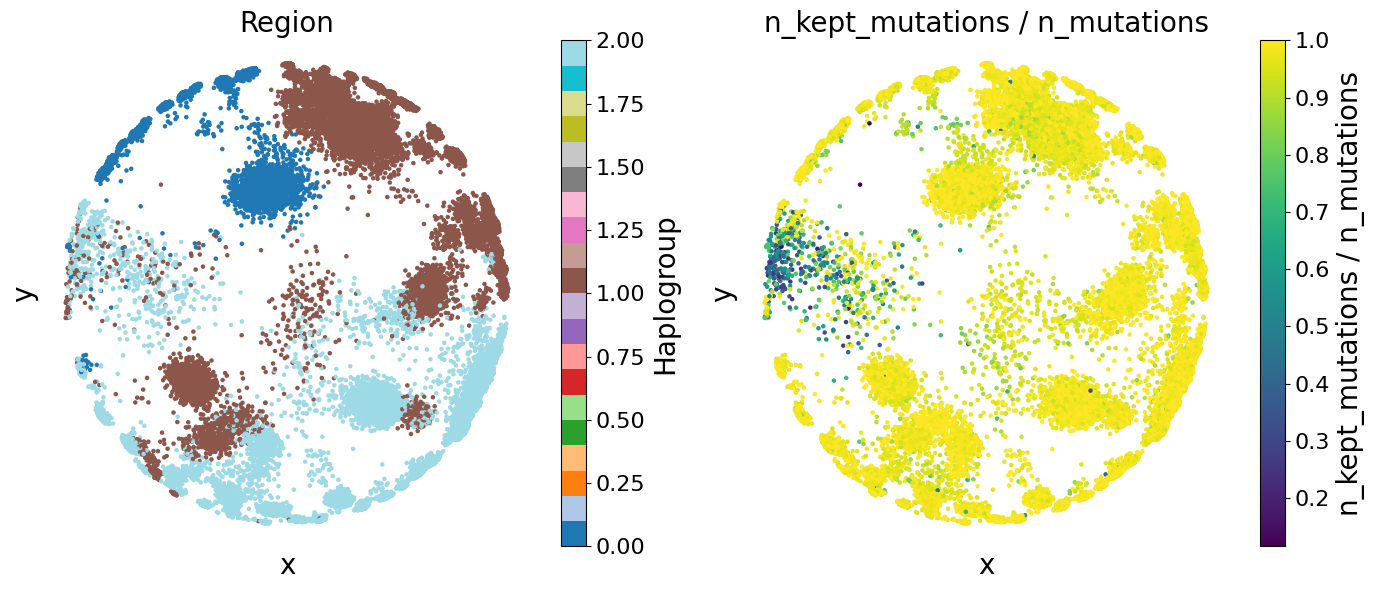

In [70]:
# convert to categorical
hap = train_data.obs.Haplogroup.str[:1].astype('category').cat.codes
muts = (train_data.obs["n_kept_mutations"]  / train_data.obs["n_mutations"]).values
z_poincare = lorentz_to_poincare(model.z) if manifold.name == 'Lorentz' else model.z
z_poincare = z_poincare.data.cpu().numpy()

c = train_data.obs['Region'].astype('category').cat.codes
# 2 subfigures showing haplogroup and mutation rate
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter = axs[0].scatter(z_poincare[:, 0], z_poincare[:, 1], c=c, cmap='tab20', s=5)
axs[0].set_title('Region')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y')
fig.colorbar(scatter, ax=axs[0], label='Haplogroup')

scatter = axs[1].scatter(z_poincare[:, 0], z_poincare[:, 1], c=muts, cmap='viridis', s=5)
axs[1].set_title('n_kept_mutations / n_mutations')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y')
fig.colorbar(scatter, ax=axs[1], label='n_kept_mutations / n_mutations')

plt.tight_layout()
plt.show()

